# HPT: Lightning With fashionMNIST

In this tutorial, we will show how `spotPython` can be integrated into the `Lightning` (`PyTorch`)
training workflow.

In [1]:
pip list | grep  "spot[RiverPython]"

spotPython                 0.2.40
spotRiver                  0.0.93
Note: you may need to restart the kernel to use updated packages.


`spotPython` can be installed via pip. Alternatively, the source code can be downloaded from gitHub: [https://github.com/sequential-parameter-optimization/spotPython](https://github.com/sequential-parameter-optimization/spotPython).

```{raw}
!pip install spotPython
```

* Uncomment the following lines if you want to for (re-)installation the latest version of `spotPython` from gitHub.

In [2]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython

## Step 1: Setup {#sec-setup-11}

Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size and the device that is used.

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* MAX_TIME is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* INIT_SIZE is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.

:::

::: {.callout-note}
### Note: Device selection

* The device can be selected by setting the variable `DEVICE`.
* Since we are using a simple neural net, the setting `"cpu"` is preferred (on Mac).
* If you have a GPU, you can use `"cuda:0"` instead.
* If DEVICE is set to `None`, `spotPython` will automatically select the device.
  * This might result in `"mps"` on Macs, which is not the best choice for simple neural nets.

:::


In [3]:
MAX_TIME = 1
INIT_SIZE = 5
DEVICE = "cpu" # "cuda:0"

In [4]:
from spotPython.utils.device import getDevice
DEVICE = getDevice(DEVICE)
print(DEVICE)

cpu


In [5]:
import os
import copy
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '11-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
print(experiment_name)
if not os.path.exists('./figures'):
    os.makedirs('./figures')

11-torch_bartz09_1min_5init_2023-06-22_19-29-51


## Step 2: Initialization of the Empty `fun_control` Dictionary

`spotPython` uses a Python dictionary for storing the information required for the hyperparameter tuning process, which was described in @sec-initialization-fun-control-14.

:::{.callout-caution}
### Caution: Tensorboard does not work under Windows
* Since tensorboard does not work under Windows, we recommend setting the parameter `tensorboard_path` to `None` if you are working under Windows.
:::


In [6]:
from spotPython.utils.init import fun_control_init
fun_control = fun_control_init(task="classification",
    tensorboard_path=None, # "runs/27_spot_hpt_torch_fashion_mnist",
    device=DEVICE)

## Step 3: PyTorch Data Loading {#sec-data-loading-11}

### Load fashionMNIST Data

In [7]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
def load_data(data_dir="./data"):

    # Download training data from open datasets.

    # Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])
    

    training_data = datasets.FashionMNIST(
        root=data_dir,
        train=True,
        download=True,
        transform=transform,
    )
    # Download test data from open datasets.
    test_data = datasets.FashionMNIST(
        root=data_dir,
        train=False,
        download=True,
        transform=transform,
    )
    return training_data, test_data

In [8]:
train, test = load_data()
train.data.shape, test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [9]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## Step 4: Specification of the Preprocessing Model {#sec-specification-of-preprocessing-model-11}

After the training and test data are specified and added to the `fun_control` dictionary, `spotPython` allows the specification of a data preprocessing pipeline, e.g., for the scaling of the data or for the one-hot encoding of categorical variables, see @sec-specification-of-preprocessing-model-14. This feature is not used here, so we do not change the default value (which is `None`).

## Step 5: Select Model (`algorithm`) and `core_model_hyper_dict` {#sec-selection-of-the-algorithm-11}


`spotPython` implements a class which is similar to the class described in the PyTorch tutorial.
The class is called `Net_fashionMNIST`  and is implemented in the file `netfashionMNIST.py`. The class is imported here.


In [10]:
from torch import nn


class BaseNetwork(nn.Module):
    def __init__(self, act_fn, _L_in=784, _L_out=10, l1=512):
        """
        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            _L_in: input_size, e.g., size of the input images in pixels
            _L_out: e.g., num_classes, number of classes we want to predict
            l1: hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        hidden_sizes = [l1, l1 // 2, l1 // 2, l1 // 4]
        layer_sizes = [_L_in] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], _L_out)]
        # A module list registers a list of modules as submodules (e.g. for parameters)
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "_L_in": _L_in,
            "_L_out": _L_out,
            "l1": l1,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

This class inherits from the class `Net_Core` which is implemented in the file `netcore.py`, see @sec-the-netcore-class-14.

In [11]:
from spotPython.data.lightning_hyper_dict import LightningHyperDict
from spotPython.lightning.basenetwork import BaseNetwork
from spotPython.hyperparameters.values import add_core_model_to_fun_control
fun_control = add_core_model_to_fun_control(core_model=BaseNetwork,
                              fun_control=fun_control,
                              hyper_dict=LightningHyperDict,
                              filename=None)

### The Search Space {#sec-search-space-11}

### Configuring the Search Space With spotPython {#sec-configuring-the-search-space-with-spotpython-11}

#### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses `JSON` files for the specification of the hyperparameters, which were described in @sec-configuring-search-space-spotpython-14.

The corresponding entries for the `core_model` class are shown below.

In [12]:
fun_control['core_model_hyper_dict']

{'_L_in': {'type': 'int',
  'default': 784,
  'transform': 'None',
  'lower': 784,
  'upper': 784},
 '_L_out': {'type': 'int',
  'default': 10,
  'transform': 'None',
  'lower': 10,
  'upper': 10},
 'l1': {'type': 'int',
  'default': 3,
  'transform': 'transform_power_2_int',
  'lower': 3,
  'upper': 8},
 'epochs': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 4,
  'upper': 9},
 'batch_size': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 1,
  'upper': 4},
 'act_fn': {'levels': ['ReLU'],
  'type': 'factor',
  'default': 'ReLU',
  'transform': 'None',
  'class_name': 'torch.nn',
  'core_model_parameter_type': 'instance()',
  'lower': 0,
  'upper': 0},
 'optimizer': {'levels': ['Adadelta',
   'Adagrad',
   'Adam',
   'AdamW',
   'SparseAdam',
   'Adamax',
   'ASGD',
   'NAdam',
   'RAdam',
   'RMSprop',
   'Rprop',
   'SGD'],
  'type': 'factor',
  'default': 'SGD',
  'transform': 'None',
  'class_name': 'torch.optim

## Step 6: Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

 `spotPython` provides functions for modifying the hyperparameters, their bounds and factors as well as for activating and de-activating hyperparameters without re-compilation of the Python source code. These functions were described in @sec-modification-of-hyperparameters-14.

### Modify hyperparameter of type numeric and integer (boolean)

The hyperparameter `k_folds` is not used, it is de-activated here by setting the lower and upper bound to the same value.

::: {.callout-caution}
### Caution: Small net size, number of epochs, and patience for demonstration purposes

* Net sizes `l1` and `l2` as well as `epochs` and `patience` are set to small values for demonstration purposes. These values are too small for a real application.
* More resonable values are, e.g.:
  * `fun_control = modify_hyper_parameter_bounds(fun_control, "l1", bounds=[2, 7])`
  * `fun_control = modify_hyper_parameter_bounds(fun_control, "epochs", bounds=[7, 9])` and
  * `fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[2, 7])`
:::

In [13]:
from spotPython.hyperparameters.values import modify_hyper_parameter_bounds
# fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])
# fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[2, 2])
fun_control = modify_hyper_parameter_bounds(fun_control, "epochs", bounds=[1, 2])
fun_control = modify_hyper_parameter_bounds(fun_control, "batch_size", bounds=[5, 7])
# fun_control = modify_hyper_parameter_bounds(fun_control, "l1", bounds=[2, 5])
# fun_control = modify_hyper_parameter_bounds(fun_control, "l2", bounds=[2, 5])

### Modify hyperparameter of type factor

In [14]:
from spotPython.hyperparameters.values import modify_hyper_parameter_levels
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer",["Adam", "AdamW", "Adamax", "NAdam"])
# fun_control = modify_hyper_parameter_levels(fun_control, "optimizer",["Adam", "SGD"])

### Optimizers {#sec-optimizers-11}

Optimizers are described in @sec-optimizers-14.

In [15]:
# fun_control = modify_hyper_parameter_bounds(fun_control, "lr_mult", bounds=[1e-3, 1e-3])
# fun_control = modify_hyper_parameter_bounds(fun_control, "sgd_momentum", bounds=[0.9, 0.9])

## Step 7: Selection of the Objective (Loss) Function

### Evaluation  {#sec-selection-of-target-function-11}

The evaluation procedure requires the specification of two elements:

1. the way how the data is split into a train and a test set and
2. the loss function (and a metric).

These are described in @sec-selection-of-target-function-24.

The key `"loss_function"` specifies the loss function which is used during the optimization, see @sec-loss-functions-14.

We will use CrossEntropy loss for the multiclass-classification task.

In [16]:
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss()
fun_control.update({
        "loss_function": loss_function,
        "shuffle": True,
        "eval":  "train_hold_out"
        })

### Metric {#sec-metric-11}

In [17]:
from torchmetrics import Accuracy
metric_torch = Accuracy(task="multiclass", num_classes=10).to(fun_control["device"])
fun_control.update({"metric_torch": metric_torch})

## Step 8: Calling the SPOT Function

### Preparing the SPOT Call {#sec-prepare-spot-call-11}

The following code passes the information about the parameter ranges and bounds to `spot`.

In [18]:
# extract the variable types, names, and bounds
from spotPython.hyperparameters.values import (get_bound_values,
    get_var_name,
    get_var_type,)
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})
lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [19]:
#| fig-cap: Experimental design for the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name       | type   | default   |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| _L_in      | int    | 784       |     784 |     784 | None                  |
| _L_out     | int    | 10        |      10 |      10 | None                  |
| l1         | int    | 3         |       3 |       8 | transform_power_2_int |
| epochs     | int    | 4         |       1 |       2 | transform_power_2_int |
| batch_size | int    | 4         |       5 |       7 | transform_power_2_int |
| act_fn     | factor | ReLU      |       0 |       0 | None                  |
| optimizer  | factor | SGD       |       0 |       3 | None                  |


### The Objective Function `fun_torch` {#sec-the-objective-function-11}

The objective function `fun_torch` is selected next. It implements an interface from `PyTorch`'s training, validation, and  testing methods to `spotPython`.


In [20]:
from spotPython.fun.hyperlightning import HyperLightning
fun = HyperLightning().fun_lightning

In [21]:
#| echo: false
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=LightningHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)

### Starting the Hyperparameter Tuning {#sec-call-the-hyperparameter-tuner-11}


config: {'_L_in': 784, '_L_out': 10, 'l1': 32, 'epochs': 2, 'batch_size': 128, 'act_fn': ReLU(), 'optimizer': 'Adamax'}
Removed attributes: {'epochs': 2, 'batch_size': 128, 'optimizer': 'Adamax'}
Optimizer initialized: Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    foreach: None
    lr: 0.002
    maximize: False
    weight_decay: 0
)


  0%|          | 0/282 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 78.94%, Validation accuracy: 84.25%


  0%|          | 0/282 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 85.86%, Validation accuracy: 86.41%


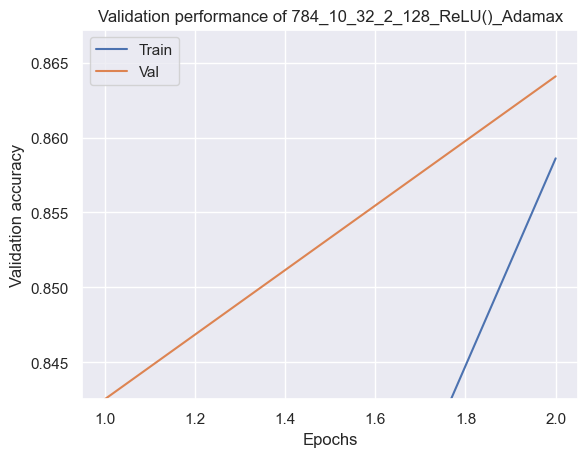

Validation Acc: 0.8640833333333333

config: {'_L_in': 784, '_L_out': 10, 'l1': 32, 'epochs': 4, 'batch_size': 32, 'act_fn': ReLU(), 'optimizer': 'Adam'}
Removed attributes: {'epochs': 4, 'batch_size': 32, 'optimizer': 'Adam'}
Optimizer initialized: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 80.21%, Validation accuracy: 84.31%


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 85.40%, Validation accuracy: 85.68%


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 87.32%, Validation accuracy: 85.99%


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 88.12%, Validation accuracy: 87.24%


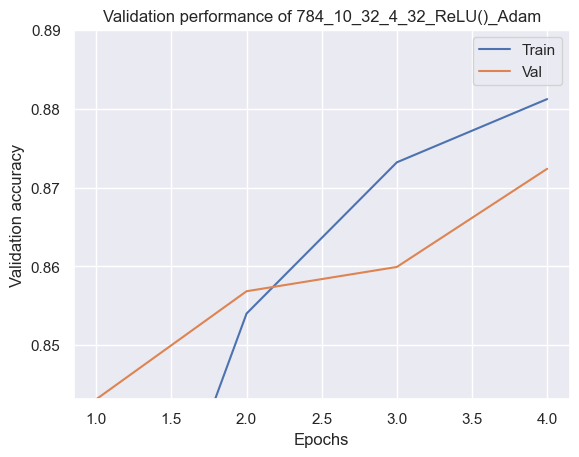

Validation Acc: 0.872375

config: {'_L_in': 784, '_L_out': 10, 'l1': 8, 'epochs': 2, 'batch_size': 32, 'act_fn': ReLU(), 'optimizer': 'NAdam'}
Removed attributes: {'epochs': 2, 'batch_size': 32, 'optimizer': 'NAdam'}
Optimizer initialized: NAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    foreach: None
    lr: 0.002
    momentum_decay: 0.004
    weight_decay: 0
)


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 79.60%, Validation accuracy: 85.30%


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 85.45%, Validation accuracy: 86.36%


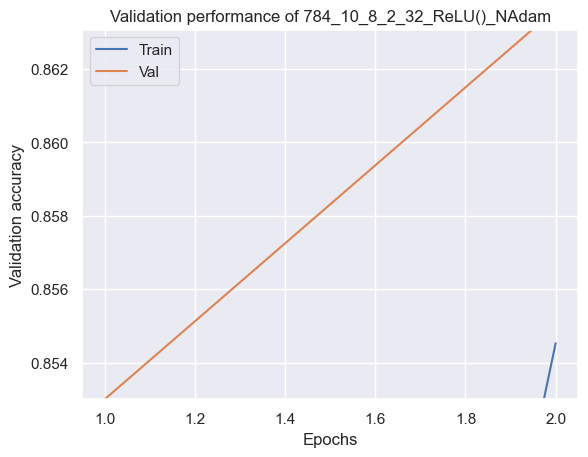

Validation Acc: 0.863625

config: {'_L_in': 784, '_L_out': 10, 'l1': 128, 'epochs': 2, 'batch_size': 64, 'act_fn': ReLU(), 'optimizer': 'AdamW'}
Removed attributes: {'epochs': 2, 'batch_size': 64, 'optimizer': 'AdamW'}
Optimizer initialized: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 79.51%, Validation accuracy: 80.35%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 85.36%, Validation accuracy: 84.65%


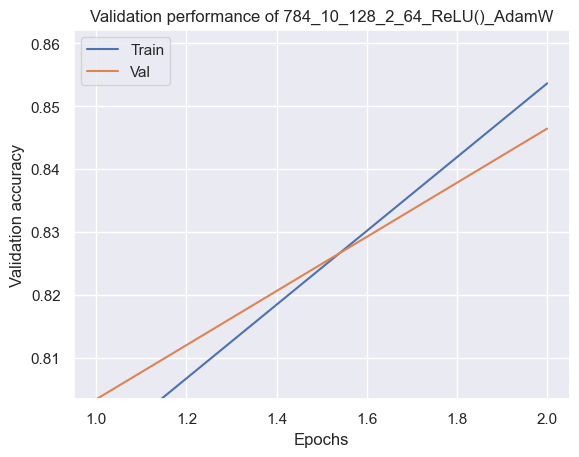

Validation Acc: 0.8464583333333333

config: {'_L_in': 784, '_L_out': 10, 'l1': 64, 'epochs': 4, 'batch_size': 64, 'act_fn': ReLU(), 'optimizer': 'AdamW'}
Removed attributes: {'epochs': 4, 'batch_size': 64, 'optimizer': 'AdamW'}
Optimizer initialized: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 79.97%, Validation accuracy: 83.77%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 86.01%, Validation accuracy: 86.20%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 87.39%, Validation accuracy: 86.67%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 88.36%, Validation accuracy: 87.98%


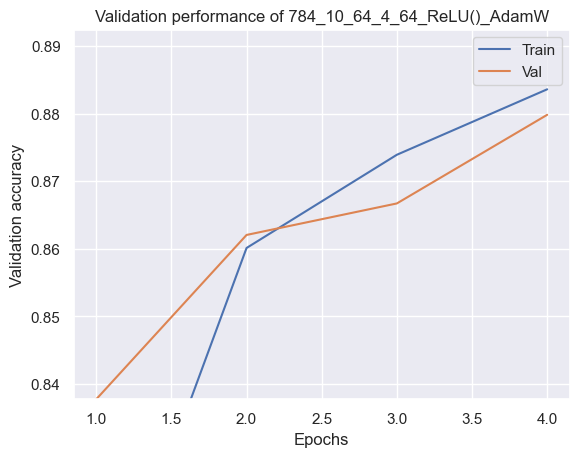

Validation Acc: 0.8798333333333334

config: {'_L_in': 784, '_L_out': 10, 'l1': 32, 'epochs': 4, 'batch_size': 64, 'act_fn': ReLU(), 'optimizer': 'Adamax'}
Removed attributes: {'epochs': 4, 'batch_size': 64, 'optimizer': 'Adamax'}
Optimizer initialized: Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    foreach: None
    lr: 0.002
    maximize: False
    weight_decay: 0
)


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 79.89%, Validation accuracy: 84.06%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 85.83%, Validation accuracy: 86.02%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 87.41%, Validation accuracy: 86.48%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 88.50%, Validation accuracy: 87.76%


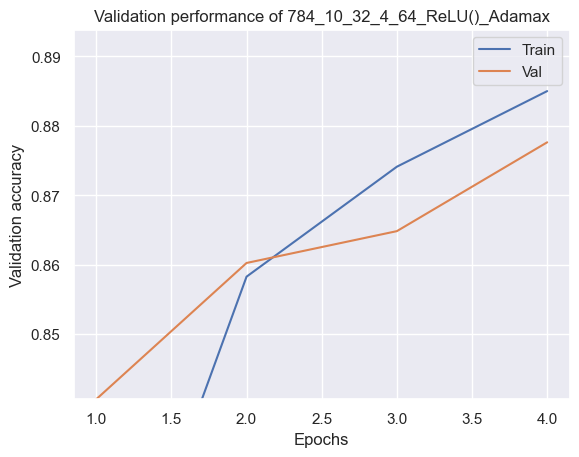

Validation Acc: 0.877625
spotPython tuning: 0.8464583333333333 [###-------] 31.62% 

config: {'_L_in': 784, '_L_out': 10, 'l1': 64, 'epochs': 4, 'batch_size': 32, 'act_fn': ReLU(), 'optimizer': 'Adam'}
Removed attributes: {'epochs': 4, 'batch_size': 32, 'optimizer': 'Adam'}
Optimizer initialized: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 80.74%, Validation accuracy: 84.92%


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 85.68%, Validation accuracy: 85.91%


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 87.12%, Validation accuracy: 86.50%


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 88.32%, Validation accuracy: 87.52%


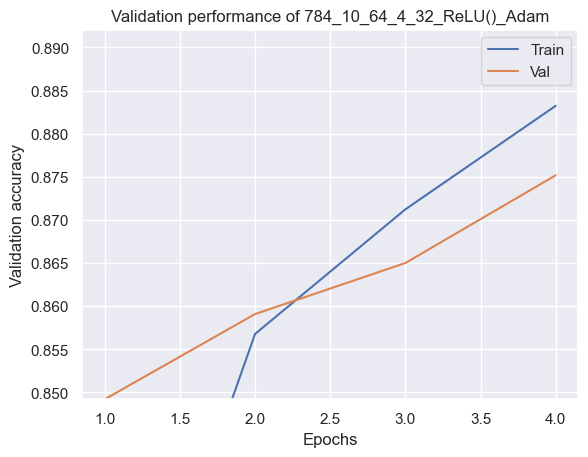

Validation Acc: 0.8751666666666666
spotPython tuning: 0.8464583333333333 [#######---] 73.90% 

config: {'_L_in': 784, '_L_out': 10, 'l1': 64, 'epochs': 4, 'batch_size': 64, 'act_fn': ReLU(), 'optimizer': 'Adamax'}
Removed attributes: {'epochs': 4, 'batch_size': 64, 'optimizer': 'Adamax'}
Optimizer initialized: Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    foreach: None
    lr: 0.002
    maximize: False
    weight_decay: 0
)


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 79.76%, Validation accuracy: 83.50%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 85.78%, Validation accuracy: 85.35%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 87.57%, Validation accuracy: 86.78%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 88.70%, Validation accuracy: 87.15%


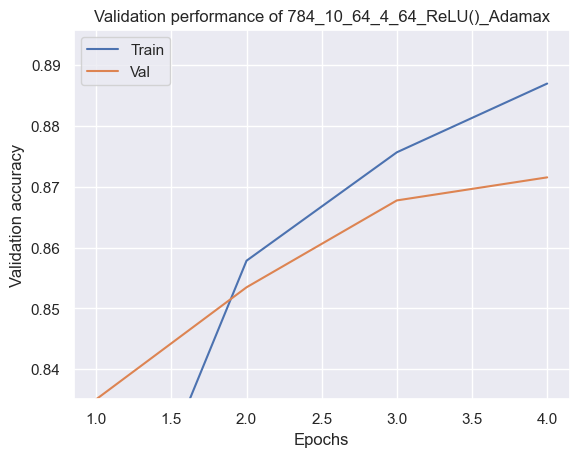

Validation Acc: 0.8715416666666667
spotPython tuning: 0.8464583333333333 [##########] 100.00% Done...



In [22]:
import numpy as np
from spotPython.spot import spot
from math import inf
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

## Step 9: Tensorboard {#sec-tensorboard-11}

The textual output shown in the console (or code cell) can be visualized with Tensorboard as described in @sec-tensorboard-14, see also the description in the documentation: [Tensorboard.](https://sequential-parameter-optimization.github.io/spotPython/14_spot_ray_hpt_torch_cifar10.html#sec-tensorboard-14)

## Step 10: Results {#sec-results-tuning-11}

After the hyperparameter tuning run is finished, the results can be analyzed as described in @sec-results-14.

In [23]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "ADD THE NAME here, e.g.: res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized. The following code generates the progress plot from @fig-progress.

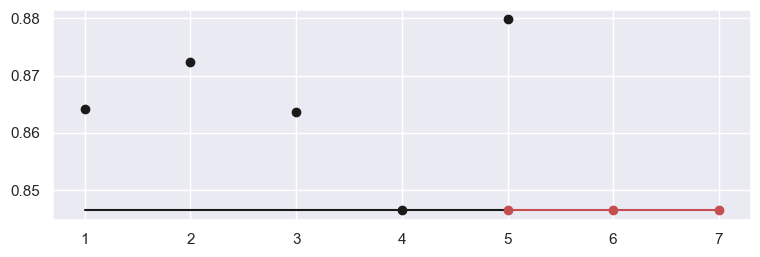

In [24]:
#| fig-cap: Progress plot. *Black* dots denote results from the initial design. *Red* dots  illustrate the improvement found by the surrogate model based optimization.
spot_tuner.plot_progress(log_y=False,
    filename="./figures/" + experiment_name+"_progress.png")

* Print the results

In [25]:
#| fig-cap: Results of the hyperparameter tuning.
print(gen_design_table(fun_control=fun_control,
    spot=spot_tuner))

| name       | type   | default   |   lower |   upper |   tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|---------|-----------------------|--------------|---------|
| _L_in      | int    | 784       |     784 |     784 |   784.0 | None                  |         0.00 |         |
| _L_out     | int    | 10        |      10 |      10 |    10.0 | None                  |         0.00 |         |
| l1         | int    | 3         |       3 |       8 |     7.0 | transform_power_2_int |         0.00 |         |
| epochs     | int    | 4         |       1 |       2 |     1.0 | transform_power_2_int |       100.00 | ***     |
| batch_size | int    | 4         |       5 |       7 |     6.0 | transform_power_2_int |         0.00 |         |
| act_fn     | factor | ReLU      |       0 |       0 |     0.0 | None                  |         0.00 |         |
| optimizer  | factor | SGD       |       0 |       3 |     1.0 | None          

### Show variable importance

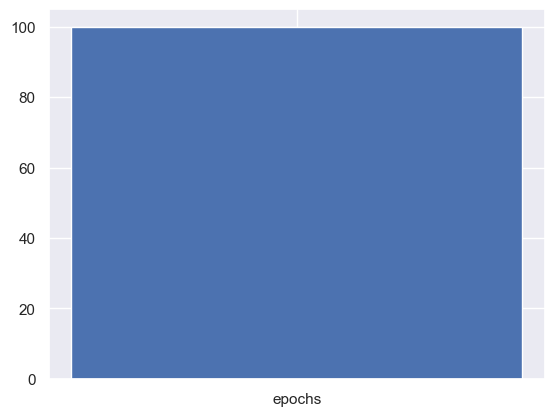

In [26]:
#| fig-cap: 'Variable importance plot, threshold 0.025.'
spot_tuner.plot_importance(threshold=0.025, filename="./figures/" + experiment_name+"_importance.png")

### Get the Tuned Architecture (SPOT Results) {#sec-get-spot-results-11}

The architecture of the `spotPython` model can be obtained by the following code:

In [27]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

### Get Default Hyperparameters

In [28]:
fc = fun_control
fc.update({"core_model_hyper_dict":
    hyper_dict[fun_control["core_model"].__name__]})
model_default = get_one_core_model_from_X(X_start, fun_control=fc)
model_default

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

### Evaluation of the Default and the Tuned Architectures

The method `train_tuned` takes a model architecture without trained weights and trains this model with the train data. The train data is split into train and validation data. The validation data is used for early stopping. The trained model weights are saved as a dictionary. 

Removed attributes: {'epochs': 2, 'batch_size': 64, 'optimizer': 'AdamW'}
Optimizer initialized: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 79.53%, Validation accuracy: 84.49%


  0%|          | 0/563 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 85.71%, Validation accuracy: 85.23%


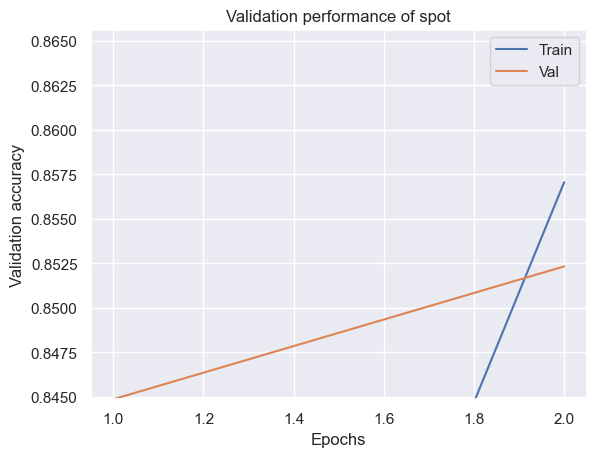

Validation Acc: 0.8523333333333334


(0.8523333333333334, nan)

In [30]:
from spotPython.lightning.traintest import train_model

train_model(net=model_spot, model_name="spot", dataset=train, shuffle=True, device=fun_control["device"])

In [ ]:
# from spotPython.torch.traintest import train_tuned
# train_tuned(net=model_default, train_dataset=train, shuffle=True,
#         loss_function=fun_control["loss_function"],
#         metric=fun_control["metric_torch"],
#         device = fun_control["device"],
#         show_batch_interval=1_000_000,
#         path=None,
#         task=fun_control["task"])

In [31]:
import torch.utils.data as data
test_loader = data.DataLoader(test, batch_size=1024, shuffle=False, drop_last=False)

In [32]:
from spotPython.lightning.traintest import test_model
test_model(net=model_spot, data_loader=test_loader, device=fun_control["device"])

0.842

In [33]:
# from spotPython.torch.traintest import test_tuned
# test_tuned(net=model_default, test_dataset=test, 
#         loss_function=fun_control["loss_function"],
#         metric=fun_control["metric_torch"],
#         shuffle=False, 
#         device = fun_control["device"],
#         task=fun_control["task"])

 The following code trains the model `model_spot`. If `path` is set to a filename, e.g., `path = "model_spot_trained.pt"`, the weights of the trained model will be saved to this file.

In [34]:
# train_tuned(net=model_spot, train_dataset=train,
#         loss_function=fun_control["loss_function"],
#         metric=fun_control["metric_torch"],
#         shuffle=True,
#         device = fun_control["device"],
#         path=None,
#         task=fun_control["task"])

In [35]:
# test_tuned(net=model_spot, test_dataset=test,
#             shuffle=False,
#             loss_function=fun_control["loss_function"],
#             metric=fun_control["metric_torch"],
#             device = fun_control["device"],
#             task=fun_control["task"])

### Detailed Hyperparameter Plots

In [36]:
#| fig-cap: Contour plots.
filename = "./figures/" + experiment_name
spot_tuner.plot_important_hyperparameter_contour(filename=filename)

epochs:  100.0


### Parallel Coordinates Plot

In [37]:
#| fig-cap: Parallel coordinates plots
spot_tuner.parallel_plot()

### Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [38]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)